In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import unidecode, re
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from scipy import *
from sklearn.feature_selection import SelectKBest, f_regression
from catboost import CatBoostClassifier
import lightgbm as lgb
import joblib
from xgboost import XGBClassifier

In [26]:
# Basic config
my_font = dict(
            family="Courier New, monospace",
            size=18,
            color="Black",
            variant="small-caps",
) 

In [119]:
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")


In [5]:
df.isnull().sum()

DT_NOTIFIC         0
CS_SEXO            0
CO_RG_RESI     73185
ID_MN_RESI        44
CS_ZONA        52838
NU_IDADE_N         0
CS_ESCOL_N    146901
CS_RACA        19384
SG_UF             44
CS_GESTANT         0
PUERPERA      298765
DIABETES      252391
PNEUMOPATI    292402
IMUNODEPRE    295546
RENAL         292734
OBESIDADE     290862
OBES_IMC      483795
CARDIOPATI    236183
SIND_DOWN     298085
HEPATICA      297733
FATOR_RISC    179966
FEBRE          60770
TOSSE          52380
GARGANTA      124438
DESC_RESP      83604
DIARREIA      129733
VOMITO        136659
FADIGA        268807
SATURACAO      77360
DISPNEIA       54168
VACINA        101083
EVOLUCAO           0
dtype: int64

In [7]:
df.groupby('SG_UF').size().reset_index(name='count').sort_values(by='count', ascending=False)

,SG_UF,count
25,SP,144896
18,RJ,54916
10,MG,37441
22,RS,25821
17,PR,25644
15,PE,22922
5,CE,19868
4,BA,17989
8,GO,17240
23,SC,16459


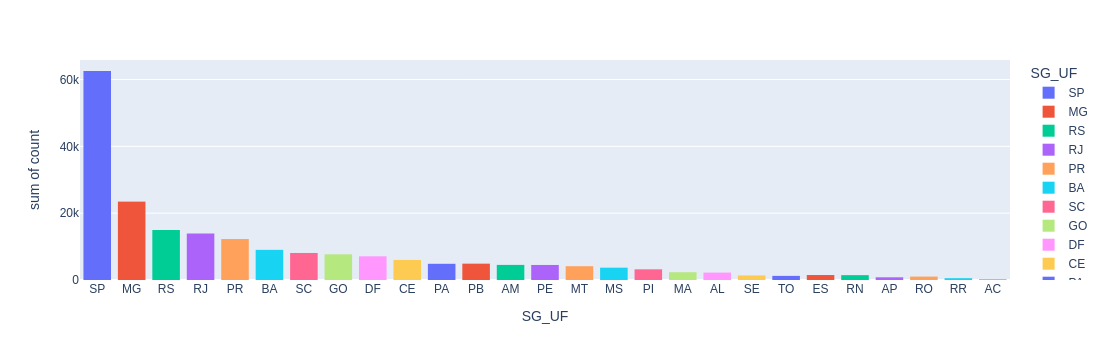

In [9]:
px.histogram(
    df.groupby(['SG_UF','OBESIDADE']).size().reset_index(name='count').sort_values(by='count', ascending=False),
    x='SG_UF',
    y='count',
    color='SG_UF')

In [10]:

x = df.groupby('GARGANTA').size().reset_index(name='count').sort_values(by='count', ascending=False)

px.histogram(
     x,
     x='GARGANTA',
     y='count',
     color='GARGANTA')
x

,GARGANTA,count
1,2.0,272810
0,1.0,88554
2,9.0,12518


In [128]:
px.histogram(
    df.groupby(['SG_UF','CS_SEXO']).size().reset_index(name='count').sort_values(by='count', ascending=False),
    x='SG_UF',
    y='count',
    color='SG_UF')

In [129]:
X_train = df.select_dtypes(['number']).drop(columns=['EVOLUCAO'])
y_train = df['EVOLUCAO']

X_test_sub = df_test.select_dtypes(['number'])

In [130]:
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size = .1, random_state=2)


In [131]:
catb = CatBoostClassifier(
    iterations=100,      
    learning_rate=0.1,   
    depth=6,              
    verbose=0             
)

catb.fit(X_train, y_train)

preds = catb.predict(X_test)

CatBoost's acurracy: 73.62%

Classification report
              precision    recall  f1-score   support

         0.0       0.76      0.87      0.81     32755
         1.0       0.65      0.49      0.56     17077

    accuracy                           0.74     49832
   macro avg       0.71      0.68      0.69     49832
weighted avg       0.73      0.74      0.73     49832



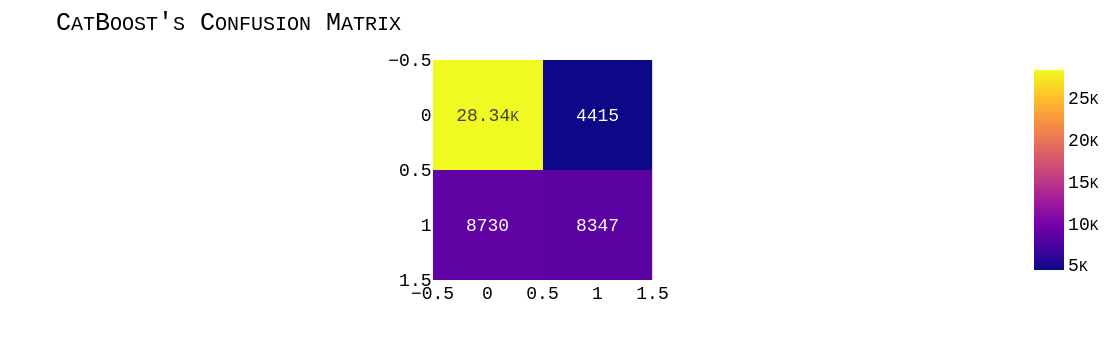

In [132]:
catboost_accuracy = accuracy_score(y_test, preds)
print(f"CatBoost's acurracy: {catboost_accuracy*100:.2f}%")

print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "CatBoost's Confusion Matrix"}, font=my_font).show()


In [133]:
test_pred = catb.predict_proba(X_test_sub)[:,1] # chances of death, class: 1.0

pd.DataFrame(np.round(test_pred)).reset_index().to_csv('results/submission_catboost.csv', header=['ID', 'EVOLUCAO'], index=False)

In [134]:
lightGBM = lgb.LGBMClassifier(random_state=23)

lightGBM.fit(X_train, y_train)

preds = lightGBM.predict(X_test)

[LightGBM] [Info] Number of positive: 154957, number of negative: 293531
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 448488, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345510 -> initscore=-0.638836
[LightGBM] [Info] Start training from score -0.638836


LightGBM acurracy: 74.38%

Classification report
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82     32755
         1.0       0.66      0.52      0.58     17077

    accuracy                           0.74     49832
   macro avg       0.72      0.69      0.70     49832
weighted avg       0.74      0.74      0.74     49832



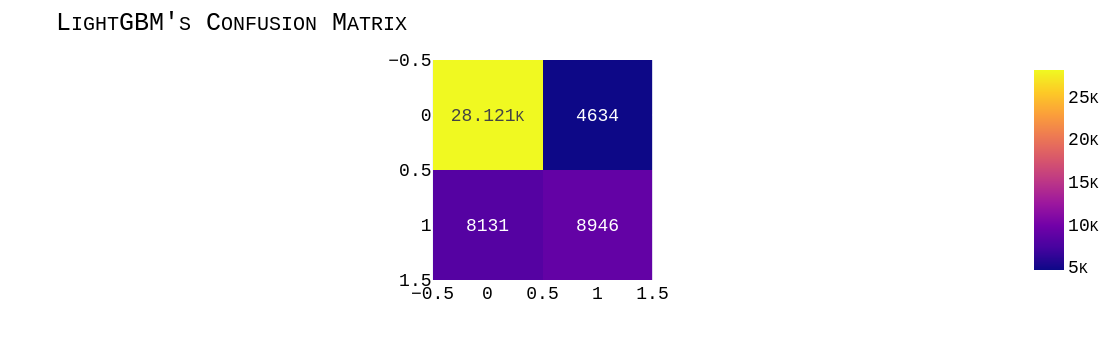

In [135]:
accuracy = lightGBM.score(X_test, y_test)


print(f"LightGBM acurracy: {accuracy*100:.2f}%")
print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "LightGBM's Confusion Matrix"}, font=my_font).show()


In [136]:
test_pred = lightGBM.predict_proba(X_test_sub)[:,1] # chances of death, class: 1.0

pd.DataFrame(np.round(test_pred)).reset_index().to_csv('results/submission_light_gbm.csv', header=['ID', 'EVOLUCAO'], index=False)

In [137]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [138]:
preds = rf.predict(X_test)
accuracy = rf.score(X_test, y_test)

print(f"Accuracy: {accuracy*100:.2f}")
print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "Random Forest's Confusion Matrix"}, font=my_font).show()



Accuracy: 73.25

Classification report
              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81     32755
         1.0       0.64      0.50      0.56     17077

    accuracy                           0.73     49832
   macro avg       0.70      0.68      0.68     49832
weighted avg       0.72      0.73      0.72     49832



In [139]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
preds = xg.predict(X_test)


In [140]:
accuracy = xg.score(X_test, y_test)

print(f"Accuracy: {accuracy*100:.2f}")
print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "XGBoost's Confusion Matrix"}, font=my_font).show()


Accuracy: 74.90

Classification report
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82     32755
         1.0       0.67      0.54      0.59     17077

    accuracy                           0.75     49832
   macro avg       0.72      0.70      0.71     49832
weighted avg       0.74      0.75      0.74     49832



In [141]:
test_pred = xg.predict_proba(X_test_sub)[:,1] # chances of death, class: 1.0

pd.DataFrame(np.round(test_pred)).reset_index().to_csv('submission_xg.csv', header=['ID', 'EVOLUCAO'], index=False)

# Now we can try to treat this dataset
- Let us start by checking what columns have more missing values
- Then we can drop rows with more that 90% of the data NaN

In [142]:
px.histogram(df.isna().sum().reset_index(name='count').sort_values(by='count', ascending=False),
            x='index', y='count', color='count', color_discrete_sequence= px.colors.sequential.Plasma_r,
             title="Most frequent columns with missing values").update_layout(font = my_font)

In [11]:
x = df.isna().sum().reset_index(name='count').sort_values(by='count', ascending=False)
x['pecentage_of_missing_data'] = (x['count'] / len(df))*100
x

,index,count,pecentage_of_missing_data
16,OBES_IMC,483795,97.085206
10,PUERPERA,298765,59.954447
18,SIND_DOWN,298085,59.817988
19,HEPATICA,297733,59.747351
13,IMUNODEPRE,295546,59.308476
14,RENAL,292734,58.744180
12,PNEUMOPATI,292402,58.677557
15,OBESIDADE,290862,58.368518
27,FADIGA,268807,53.942647
11,DIABETES,252391,50.648379


In [12]:
px.histogram(df.isna().sum().reset_index(name='count').sort_values(by='count', ascending=True).head(20),
            x='index', y='count', color='count', color_discrete_sequence= px.colors.sequential.Plasma_r,
             title="Less frequent columns with missing values").update_layout(font = my_font)

NameError: name 'my_font' is not defined

In [13]:
missing_counts = df.isnull().sum(axis=1)
thresh = 27
df_no_nulls = df[missing_counts < thresh]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498320 entries, 0 to 498319
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   DT_NOTIFIC  498320 non-null  object 
 1   CS_SEXO     498320 non-null  object 
 2   CO_RG_RESI  425135 non-null  float64
 3   ID_MN_RESI  498276 non-null  object 
 4   CS_ZONA     445482 non-null  float64
 5   NU_IDADE_N  498320 non-null  int64  
 6   CS_ESCOL_N  351419 non-null  float64
 7   CS_RACA     478936 non-null  float64
 8   SG_UF       498276 non-null  object 
 9   CS_GESTANT  498320 non-null  int64  
 10  PUERPERA    199555 non-null  float64
 11  DIABETES    245929 non-null  float64
 12  PNEUMOPATI  205918 non-null  float64
 13  IMUNODEPRE  202774 non-null  float64
 14  RENAL       205586 non-null  float64
 15  OBESIDADE   207458 non-null  float64
 16  OBES_IMC    14525 non-null   float64
 17  CARDIOPATI  262137 non-null  float64
 18  SIND_DOWN   200235 non-null  float64
 19  HE

### Note: You cannot just filter out all columns with ANY missing values
 - The accuracy of all models pretty much drops drastically

### Checking correlation between variables

<Axes: >

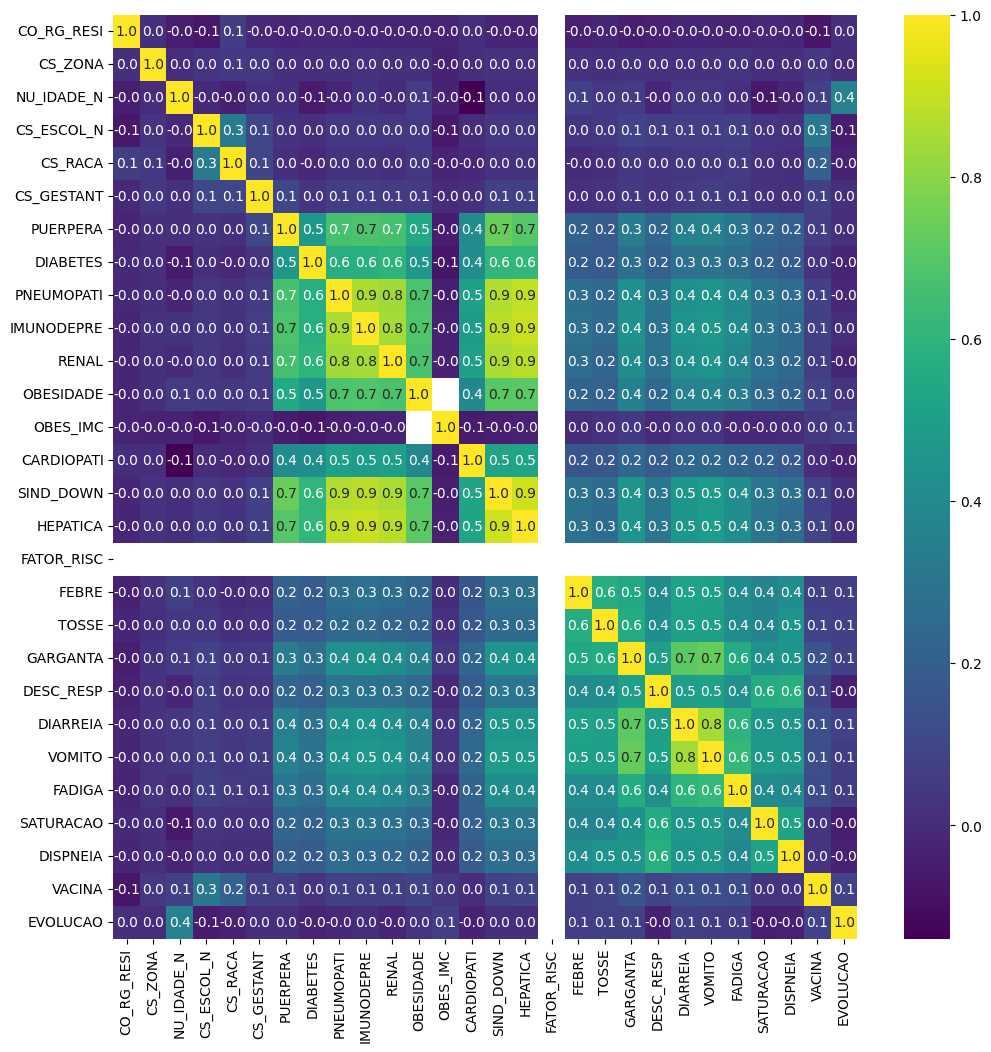

In [14]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis', fmt=".1f")

## Frist, we can create a total_comorbities columns to represent the total amount of comordities one has.
    - We will separate it in chronic and temporary

In [15]:
df_no_nulls['total_chronic_cormodity'] = ((df_no_nulls[["OBESIDADE", 
                                                        "RENAL", 
                                                        "CARDIOPATI",
                                                        "IMUNODEPRE", 
                                                        "DIABETES", 
                                                        "PNEUMOPATI",
                                                        "HEPATICA",
                                                        "SIND_DOWN"]] == 1.0).sum(axis=1))

df_no_nulls['total_temporary_cormodity'] = (df_no_nulls[["FEBRE",
                                                        "TOSSE",
                                                        "PUERPERA",
                                                        "GARGANTA",
                                                        "DESC_RESP",
                                                        "DIARREIA",
                                                        "VOMITO",
                                                        "FADIGA",
                                                        "SATURACAO",
                                                        "DISPNEIA"]]== 1.0).sum(axis=1)

In [16]:
x.head()

,index,count,pecentage_of_missing_data
16,OBES_IMC,483795,97.085206
10,PUERPERA,298765,59.954447
18,SIND_DOWN,298085,59.817988
19,HEPATICA,297733,59.747351
13,IMUNODEPRE,295546,59.308476


# Creating a function to handle missing values

In [150]:
def fill_null_rows(dataframe, columns_to_fill, missing_value):
    for col in columns_to_fill:
        dataframe[col] = dataframe[col].astype('category')
        if col in dataframe.columns:
            dataframe.fillna(missing_value, inplace=True)
    return dataframe


df_2 = df_no_nulls.copy()


columns_to_fill = [
                   "OBESIDADE", 
                   "RENAL", 
                   "CARDIOPATI",
                   "IMUNODEPRE", 
                   "DIABETES", 
                   "PNEUMOPATI",
                   "HEPATICA",
                   "FEBRE",
                   "TOSSE",
                   "GARGANTA",
                   "DESC_RESP",
                   "DIARREIA",
                   "VOMITO",
                   "FADIGA",
                   "SATURACAO",
                   "DISPNEIA",
                   "CS_RACA",
                   "CS_ZONA",
                   "VACINA",
                   "CS_ESCOL_N",
                   "FATOR_RISC",
                   "SIND_DOWN",
                   "CO_RG_RESI"
                  ] # 22 columns 



df_2 = fill_null_rows(df_2, columns_to_fill, 9)



missing_columns = ["CS_SEXO", "EVOLUCAO", "CS_GESTANT", "SG_UF"]


for col in missing_columns:
        df_2[col] = df_2[col].astype('category')

In [151]:
df_2.drop(columns={"DT_NOTIFIC", "ID_MN_RESI","OBES_IMC", "CO_RG_RESI"}, inplace=True)
# CO_RG_RESI
# , "TOSSE"
# removing: SG_UF
# "SG_UF",
df_2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498320 entries, 0 to 498319
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   CS_SEXO                    498320 non-null  category
 1   CS_ZONA                    498320 non-null  category
 2   NU_IDADE_N                 498320 non-null  int64   
 3   CS_ESCOL_N                 498320 non-null  category
 4   CS_RACA                    498320 non-null  category
 5   SG_UF                      498320 non-null  category
 6   CS_GESTANT                 498320 non-null  category
 7   PUERPERA                   498320 non-null  float64 
 8   DIABETES                   498320 non-null  category
 9   PNEUMOPATI                 498320 non-null  category
 10  IMUNODEPRE                 498320 non-null  category
 11  RENAL                      498320 non-null  category
 12  OBESIDADE                  498320 non-null  category
 13  CARDIOPATI    

In [152]:
X = df_2.drop('EVOLUCAO', axis=1)
not_encoded_y = df_2['EVOLUCAO']

X_one_hot_encoded = pd.get_dummies(X, drop_first=True, dtype=float)

In [153]:
X_train, X_test, y_train, y_test= train_test_split(X_one_hot_encoded , not_encoded_y, test_size = .3, random_state=2)

In [154]:
le = LabelEncoder()
y = le.fit_transform(not_encoded_y)
print(list(le.classes_))

from sklearn.feature_selection import SelectKBest, f_regression, chi2
X_ = X_one_hot_encoded

selector = SelectKBest(score_func=chi2, k=6)
X_new = selector.fit_transform(X_, y)
selected_features = selector.get_feature_names_out(input_features=X_.columns)
print(selected_features)

[np.float64(0.0), np.float64(1.0)]
['NU_IDADE_N' 'PUERPERA' 'total_chronic_cormodity' 'FATOR_RISC_9.0'
 'SATURACAO_2.0' 'DISPNEIA_2.0']


In [155]:
lightGBM = lgb.LGBMClassifier(random_state=23)
lightGBM.fit(X_train, y_train)
preds = lightGBM.predict(X_test)


[LightGBM] [Info] Number of positive: 120464, number of negative: 228360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 348824, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345343 -> initscore=-0.639572
[LightGBM] [Info] Start training from score -0.639572


LightGBM acurracy: 74.10%

Classification report
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81     97926
         1.0       0.66      0.52      0.58     51570

    accuracy                           0.74    149496
   macro avg       0.71      0.69      0.70    149496
weighted avg       0.73      0.74      0.73    149496



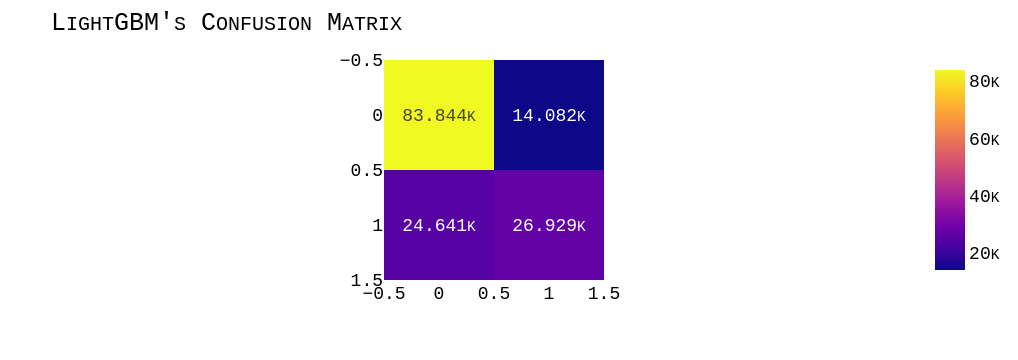

In [156]:
accuracy = lightGBM.score(X_test, y_test)

print(f"LightGBM acurracy: {accuracy*100:.2f}%")
print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "LightGBM's Confusion Matrix"}, font=my_font).show()


In [123]:
df_test['total_chronic_cormodity'] = ((df_test[["OBESIDADE", 
                                                        "RENAL", 
                                                        "CARDIOPATI",
                                                        "IMUNODEPRE", 
                                                        "DIABETES", 
                                                        "PNEUMOPATI",
                                                        "HEPATICA",
                                                        "SIND_DOWN"]] == 1.0).sum(axis=1))

df_test['total_temporary_cormodity'] = (df_test[["FEBRE",
                                                        "TOSSE",
                                                        "PUERPERA",
                                                        "GARGANTA",
                                                        "DESC_RESP",
                                                        "DIARREIA",
                                                        "VOMITO",
                                                        "FADIGA",
                                                        "SATURACAO",
                                                        "DISPNEIA"]]== 1.0).sum(axis=1)



In [141]:
df_test

,CO_RG_RESI,CS_ZONA,NU_IDADE_N,CS_ESCOL_N,CS_RACA,CS_GESTANT,PUERPERA,DIABETES,PNEUMOPATI,IMUNODEPRE,...,GARGANTA,DESC_RESP,DIARREIA,VOMITO,FADIGA,SATURACAO,DISPNEIA,VACINA,total_chronic_cormodity,total_temporary_cormodity
0,1608.0,1.0,60,9.0,1.0,9,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,2.0,1.0,1.0,1.0,9.0,0,7
1,1497.0,1.0,28,0.0,9.0,6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,3
2,1533.0,0.0,45,0.0,0.0,6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,3
3,1331.0,0.0,38,0.0,4.0,5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,3
4,1498.0,1.0,50,0.0,4.0,6,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,0.0,1.0,1.0,0.0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124576,1411.0,1.0,39,4.0,1.0,5,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,0.0,1.0,1.0,9.0,0,3
124577,1342.0,1.0,37,3.0,1.0,6,2.0,1.0,2.0,2.0,...,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1,5
124578,1558.0,1.0,34,4.0,1.0,6,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,0.0,2.0,2.0,9.0,0,2
124579,5586.0,1.0,78,1.0,4.0,5,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1,7
